## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY

https://github.com/cdt59/MPPP


In [106]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
from scipy import stats
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

import Metashape

%run MPPP.py

%matplotlib inline

# directory_input  = 'C:/Users/cdt59/Desktop/agisoft/data'
directory_input  = 'Z:/Mastcam-Z/agisoft/data/zcam'




In [2]:

doc = Metashape.Document( read_only=1 )
# doc.open(path="C:/Users/cdt59/Desktop/agisoft/m36_site.psx")
doc.open(path="Z:/Mastcam-Z/agisoft/jezero/m32_site_cal690_.psx")



In [123]:
cam_ID = 'ZL'
zoom_ID = '034'

In [13]:
%%time

%run MPPP.py

N_cams = len( doc.chunk.cameras )

ns  = []
fs  = []
cxs = []
cys = []
fos = []

for i in range( N_cams ):
    
    cam = doc.chunk.cameras[ i ]
    
    if cam.enabled:
        if cam.label[:2] == cam_ID and cam.label[45:48] == zoom_ID:
            
            cam = doc.chunk.cameras[ i ]
            
            IMG_path = glob.glob( directory_input + '/*/' + cam.label[:54] + '.IMG' )
            
            if len(IMG_path):
                im = image( IMG_path[0], just_label=1 )

                fos.append( im.focus_mc )            
                ns .append( cam.label )
                fs .append( cam.calibration.f )
                cxs.append( cam.calibration.cx )
                cys.append( cam.calibration.cy )


Wall time: 1min 42s


<Figure size 640x480 with 0 Axes>

In [14]:
fos = np.array( fos )
cxs = np.array( cxs )
cys = np.array( cys )
ns  = np.array( ns  )
fs  = np.array( fs  )

fos

array([  210,   270,   420,   420,   264,   138,   138,   138,   138,
         138,   138,   138,    72,    72,   270,   270,   270,   270,
         270,   270,   270,   270,   420,   420,   420,   420,   420,
         420,   420,   420,   420,   624,   624,   624,   624,   624,
         624,   624,   624,   624,   624,   624,   624,   624,   624,
         624,   624,   624,   834,   834,   834,   834,   834,   834,
         834,   834,   834,   834,   834,   834,   834,   834,   834,
         834,   834,   834,   834,   834,  1062,  1062,  1062,  1062,
        1062,  1062,  1062,  1062,  1032,  1032,  1032,  1032,  1032,
        1032,  1032,  1032,  1032,  1032,  1032,  1062,  1062,  1062,
         216,   -48,   114,    84,  -102,   -12,   -12,  -744,  -744,
        -744,  -744, -1026, -1026, -1026,  -378,  -264,  -612,  -264,
        -402,  -504,  -780,  -810,  -666,  -666,  -834, -1056,  -762,
       -1104, -1056, -1620, -1548, -1086, -1056, -1080, -1008, -1584,
       -1542, -1422,

In [15]:
a = np.vstack( [ns,fos,fs,cxs,cys] ) 
n = cam_ID + '_' + zoom_ID + ".csv"
pd.DataFrame( a.T, columns=['name','focus','f','cx','cy'] ).to_csv( n, index=0 )

In [124]:
n = cam_ID + '_' + zoom_ID + ".csv"
df = pd.read_csv( n )

In [125]:
D_min, D_near, D_med = [ 1, 3.0, 6.0 ] 

    
if cam_ID == 'ZL':
    B,A = [ 1216.2, 2194 ]
if cam_ID == 'ZR':
    B,A = [ 1276.6, 2264 ]
                    
def dist_AB( mc_focus, A, B ):
    return A / ( B - np.array( mc_focus ) )

def focus_AB( dist, A, B ):
    return B - A / np.array( dist )

focus_min  = focus_AB( D_min , A, B )
focus_near = focus_AB( D_near, A, B )
focus_med  = focus_AB( D_med , A, B )

In [126]:
pf_ = np.polyfit( df.focus, df.f, 1 )
fs_  = np.polyval( pf_, df.focus )
df = df[ np.abs(df.f - fs_) < 50 ]

pf_ = np.polyfit( df.focus, df.f, 1 )
fs_  = np.polyval( pf_, df.focus )
df = df[ np.abs(df.f - fs_) < 20 ]

In [127]:
# ZL 34mm
fos_cahvor = [ -1154, -284 ,  48,  426,  498 ]
fs_cahvor  = [ 4593.459924, 4635.946265, 4654.881698, 4673.225441, 4676.606105]


# # ZR 34mm
# fos_cahvor = [ -1142, -266 ,  114,  426,  480 ]
# fs_cahvor  = [ 4602.707383, 4643.703681, 4661.593817, 4676.253200, 4679.110562]

('ZL_034.csv', array([  4.93974088e-02,   4.68814160e+03]))

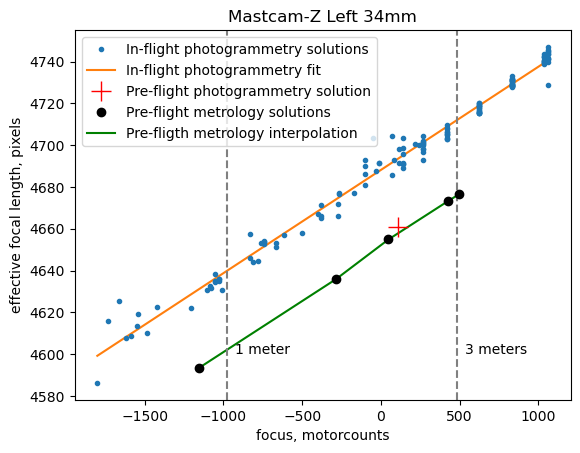

In [130]:

# def polyfit_zscore( x, y, deg = 1 ):
#     df = pd.DataFrame(zip(x, y))
#     plt.plot( df[0],df[1], 'r.' )
#     df = df[(np.abs(stats.zscore(df)) < 2 ).all(axis=1)]
#     plt.plot( df[0],df[1], 'b.' )
#     return np.polyfit(df[0], df[1], deg)

pf_ = np.polyfit( df.focus, df.f, 1 )

fos_ = np.linspace( np.min(df.focus), np.max(df.focus), 100 )
fs_  = np.polyval( pf_, fos_ )

plt.plot( df.focus, df.f, '.')
plt.plot( fos_, fs_, '-', zorder=0)

plt.plot( [108+2], [34.49/0.0074], '+r', ms=15, zorder=4 )

plt.plot( fos_cahvor, fs_cahvor, 'ok')
plt.plot( fos_cahvor, fs_cahvor, '-', color='green', zorder=0)



plt.axvline( focus_min, color='grey', ls = '--', zorder = 0 )
plt.axvline( focus_near, color='grey', ls = '--', zorder = 0 )
plt.text( focus_min+50, 4600,'1 meter')
plt.text( focus_near+50, 4600,'3 meters')
# plt.ylim([4578,4760])

# plt.axvline( focus_med , color='green', ls = '--' )

plt.legend(['In-flight photogrammetry solutions','In-flight photogrammetry fit', 
            'Pre-flight photogrammetry solution',
            'Pre-flight metrology solutions', 'Pre-fligth metrology interpolation',
            ])
plt.title('Mastcam-Z Left 34mm')
plt.xlabel('focus, motorcounts')
plt.ylabel('effective focal length, pixels')

plt.savefig( n[:-4] + '_f.png', dpi = 400)

n, pf_

('ZR_034.csv', array([  5.08587441e-02,   4.69407043e+03]))

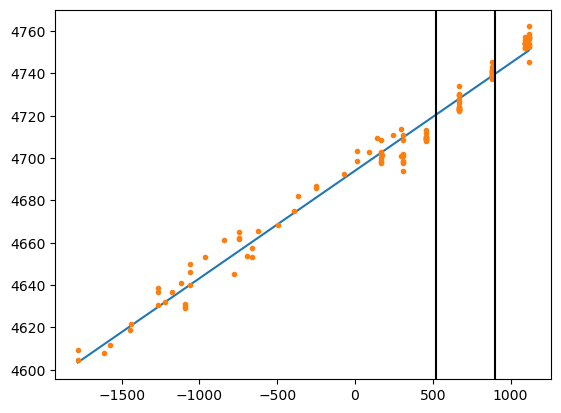

In [11]:

# def polyfit_zscore( x, y, deg = 1 ):
#     df = pd.DataFrame(zip(x, y))
#     plt.plot( df[0],df[1], 'r.' )
#     df = df[(np.abs(stats.zscore(df)) < 2 ).all(axis=1)]
#     plt.plot( df[0],df[1], 'b.' )
#     return np.polyfit(df[0], df[1], deg)

pf_ = np.polyfit( df.focus, df.f, 1 )

fos_ = np.linspace( np.min(df.focus), np.max(df.focus), 100 )
fs_  = np.polyval( pf_, fos_ )

plt.plot( fos_, fs_, '-')
plt.plot( df.focus, df.f, '.')

plt.axvline( focus_near, color='k' )
plt.axvline( focus_med , color='k' )

n, pf_

0.171875

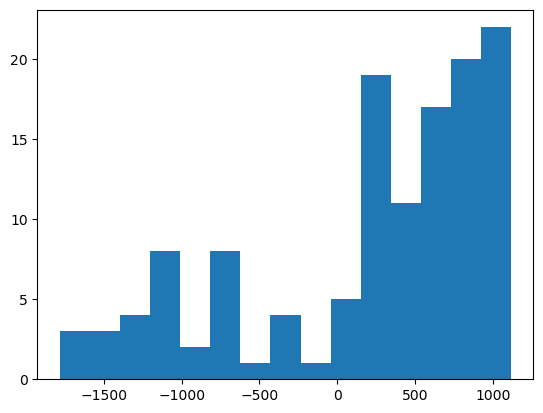

In [13]:
plt.hist( fos, 15 )

n_near = len(np.array( fos )[ np.array( fos ) <focus_near ])
n_far  = len(np.array( fos )[ np.array( fos ) >focus_med ])
n_all  = len( fos )
n_med  = n_all - n_near - n_far

n_far/n_all

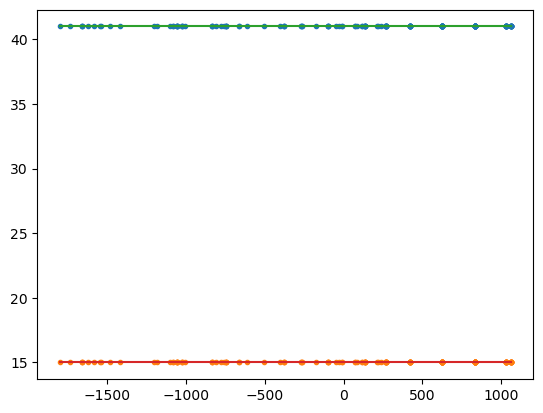

In [26]:
plt.plot( fos, cxs, '.')
plt.plot( fos, cys, '.')

pcx_ = np.polyfit( fos, cxs, 2 )
pcy_ = np.polyfit( fos, cys, 2 )

cxs_  = np.polyval( pcx_, fos_ )
cys_  = np.polyval( pcy_, fos_ )


plt.plot( fos_, cxs_, '-')
plt.plot( fos_, cys_, '-')

In [43]:
mc_focus_far = np.mean(np.array( fos )[ np.array( fos ) >focus_med ], dtype = 'int')
mc_focus_mid = np.mean(np.array( fos )[ np.array( fos ) <focus_med ], dtype = 'int')

mc_focus_mid, mc_focus_far

(-75, 1052)

In [135]:
mc_focus = mc_focus_mid

f  = np.polyval( pf_ , mc_focus )
cx = np.polyval( pcx_, mc_focus )
cy = np.polyval( pcy_, mc_focus )


cam_ID, mc_focus, 'mid', f, cx, cy 

('ZL', -75, 'mid', 0.0, 0.0, 0.0)

In [45]:
mc_focus = mc_focus_far

f  = np.polyval( pf_ , mc_focus )
cx = np.polyval( pcx_, mc_focus )
cy = np.polyval( pcy_, mc_focus )


cam_ID, mc_focus, 'far', f, cx, cy 

('ZL', 1052, 'far', 4743.5401939972098, 44.000000000000021, 13.000000000000009)

In [ ]:
mc_focus = mc_focus_mid

f  = np.polyval( pf_ , mc_focus )
cx = np.polyval( pcx_, mc_focus )
cy = np.polyval( pcy_, mc_focus )


cam_ID, mc_focus, 'mid', f, cx, cy 

In [ ]:
mc_focus = mc_focus_far

f  = np.polyval( pf_ , mc_focus )
cx = np.polyval( pcx_, mc_focus )
cy = np.polyval( pcy_, mc_focus )


cam_ID, mc_focus, 'far', f, cx, cy 

In [132]:
path = 'C:/Users/cdt59/Desktop/agisoft/m32_site_cal690_rnav_c.txt'

df = pd.read_csv( path, skiprows=1, ) 
df

,#Label,Enable,X,Y,Z,Omega,Phi,Kappa,Error_(m),X_error,...,Error_(deg),Omega_error,Phi_error,Kappa_error,X_est,Y_est,Z_est,Omega_est,Phi_est,Kappa_est
0,NLF_0693_0728460284_145RZS_N0321208NCAM08111_0...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.351105,-1.906950,1.875063,55.891088,-1.574703,-0.579844
1,NRF_0693_0728460284_145RZS_N0321208NCAM08111_0...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.772127,-1.921529,1.878545,55.989582,-1.567398,-0.656582
2,ZL0_0414_0703684096_456RAD_N0220788ZCAM08428_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZL0_0414_0703684150_456RAD_N0220788ZCAM08428_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZL0_0414_0703684168_488RAD_N0220788ZCAM08428_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,ZR0_0693_0728466260_818RAD_N0321214ZCAM08689_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1275,ZR0_0693_0728466283_818RAD_N0321214ZCAM08689_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1276,ZR0_0693_0728466379_818RAD_N0321214ZCAM08689_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1277,ZR0_0693_0728466404_818RAD_N0321214ZCAM08689_1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  0.,   0.,   0.,   1.,   1.,   5.,  10.,  22.,  33.,  68.,  78.,
         53.,  24.,   4.,   2.,   1.,   0.,   0.,   0.,   0.]),
 array([-0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
        -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,
         0.006,  0.007,  0.008,  0.009,  0.01 ]),
 <BarContainer object of 20 artists>)

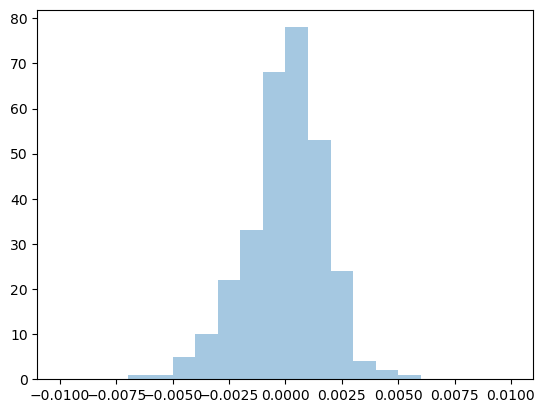

In [139]:
bins = np.linspace(-0.01,0.01,21)

plt.hist( df.X-df.X_est, bins=bins, alpha = 0.4 )
# plt.hist( df.Y-df.Y_est, bins=bins, alpha = 0.4 )
# plt.hist( df.Z-df.Z_est, bins=bins, alpha = 0.4 )

In [138]:
np.std(df.X_error), np.std(df.Y_error), np.std(df.Z_error)

(0.001727812875601321, 0.001681370062037704, 0.0023258191452901855)

(array([  0.,   3.,   1.,   1.,   2.,   3.,   1.,   0.,   2.,   1.,   8.,
          8.,   3.,  13.,   4.,   2.,   3.,   2.,   1.,   2.]),
 array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
        -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09,  0.1 ]),
 <BarContainer object of 20 artists>)

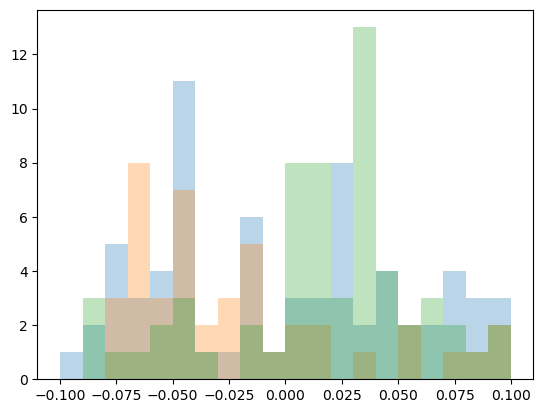

In [105]:
bins = np.linspace(-0.1,0.1,21)

plt.hist( df.Kappa-df.Kappa_est, bins=bins, alpha = 0.3 )
plt.hist( df.Omega-df.Omega_est, bins=bins, alpha = 0.3 )
plt.hist( df.Phi-df.Phi_est, bins=bins, alpha = 0.3 )


In [ ]:
path = 'C:/Users/cdt59/Documents/MPPP_workspace/zcam_cal_sol_690/m20_cmods/M2020_CAL_001_SN_4007_MCZL_Z02448_F00048_FLIGHT_RNAV.cahvor'


